In [1]:
import numpy as np 
import jax
import jax.numpy as jnp 
from flowMC.nfmodel.realNVP import RealNVP
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
import jax
import os
import optax
import equinox as eqx  # Equinox
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from flowMC.Sampler import Sampler
from flowMC.proposal.MALA import MALA

In [18]:
params_array = np.load("params_array_from_lhc_new.npy")
data = jnp.array(params_array)[:80000]

# Model parameters
n_feature = 82
n_layers = 12
n_hiddens = [128,128]
n_bins = 8
key, subkey = jax.random.split(jax.random.PRNGKey(1))


In [16]:
data_cov=jnp.cov(data.T)

In [17]:
data_cov.shape 

(82, 82)

In [3]:

model = MaskedCouplingRQSpline(
    n_feature,
    n_layers,
    n_hiddens,
    n_bins,
    subkey,
    data_cov=jnp.cov(data.T),
    data_mean=jnp.mean(data, axis=0),
)

num_epochs = 150
batch_size = 10000
learning_rate = 0.001

optim = optax.adam(learning_rate)
state = optim.init(eqx.filter(model, eqx.is_array))
key, subkey = jax.random.split(key)
key, model, state, loss = model.train(key, data, optim, state, num_epochs, batch_size, verbose=True)

Training NF, current loss: -213.064: 100%|██████████| 150/150 [02:01<00:00,  1.23it/s]


In [4]:
key, subkey = jax.random.split(key, 2)
nf_samples = model.sample(subkey, 10000, sigma_factor=2)

/scratch/tmp.11134737.areeves/ipykernel_1942453/3052891419.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


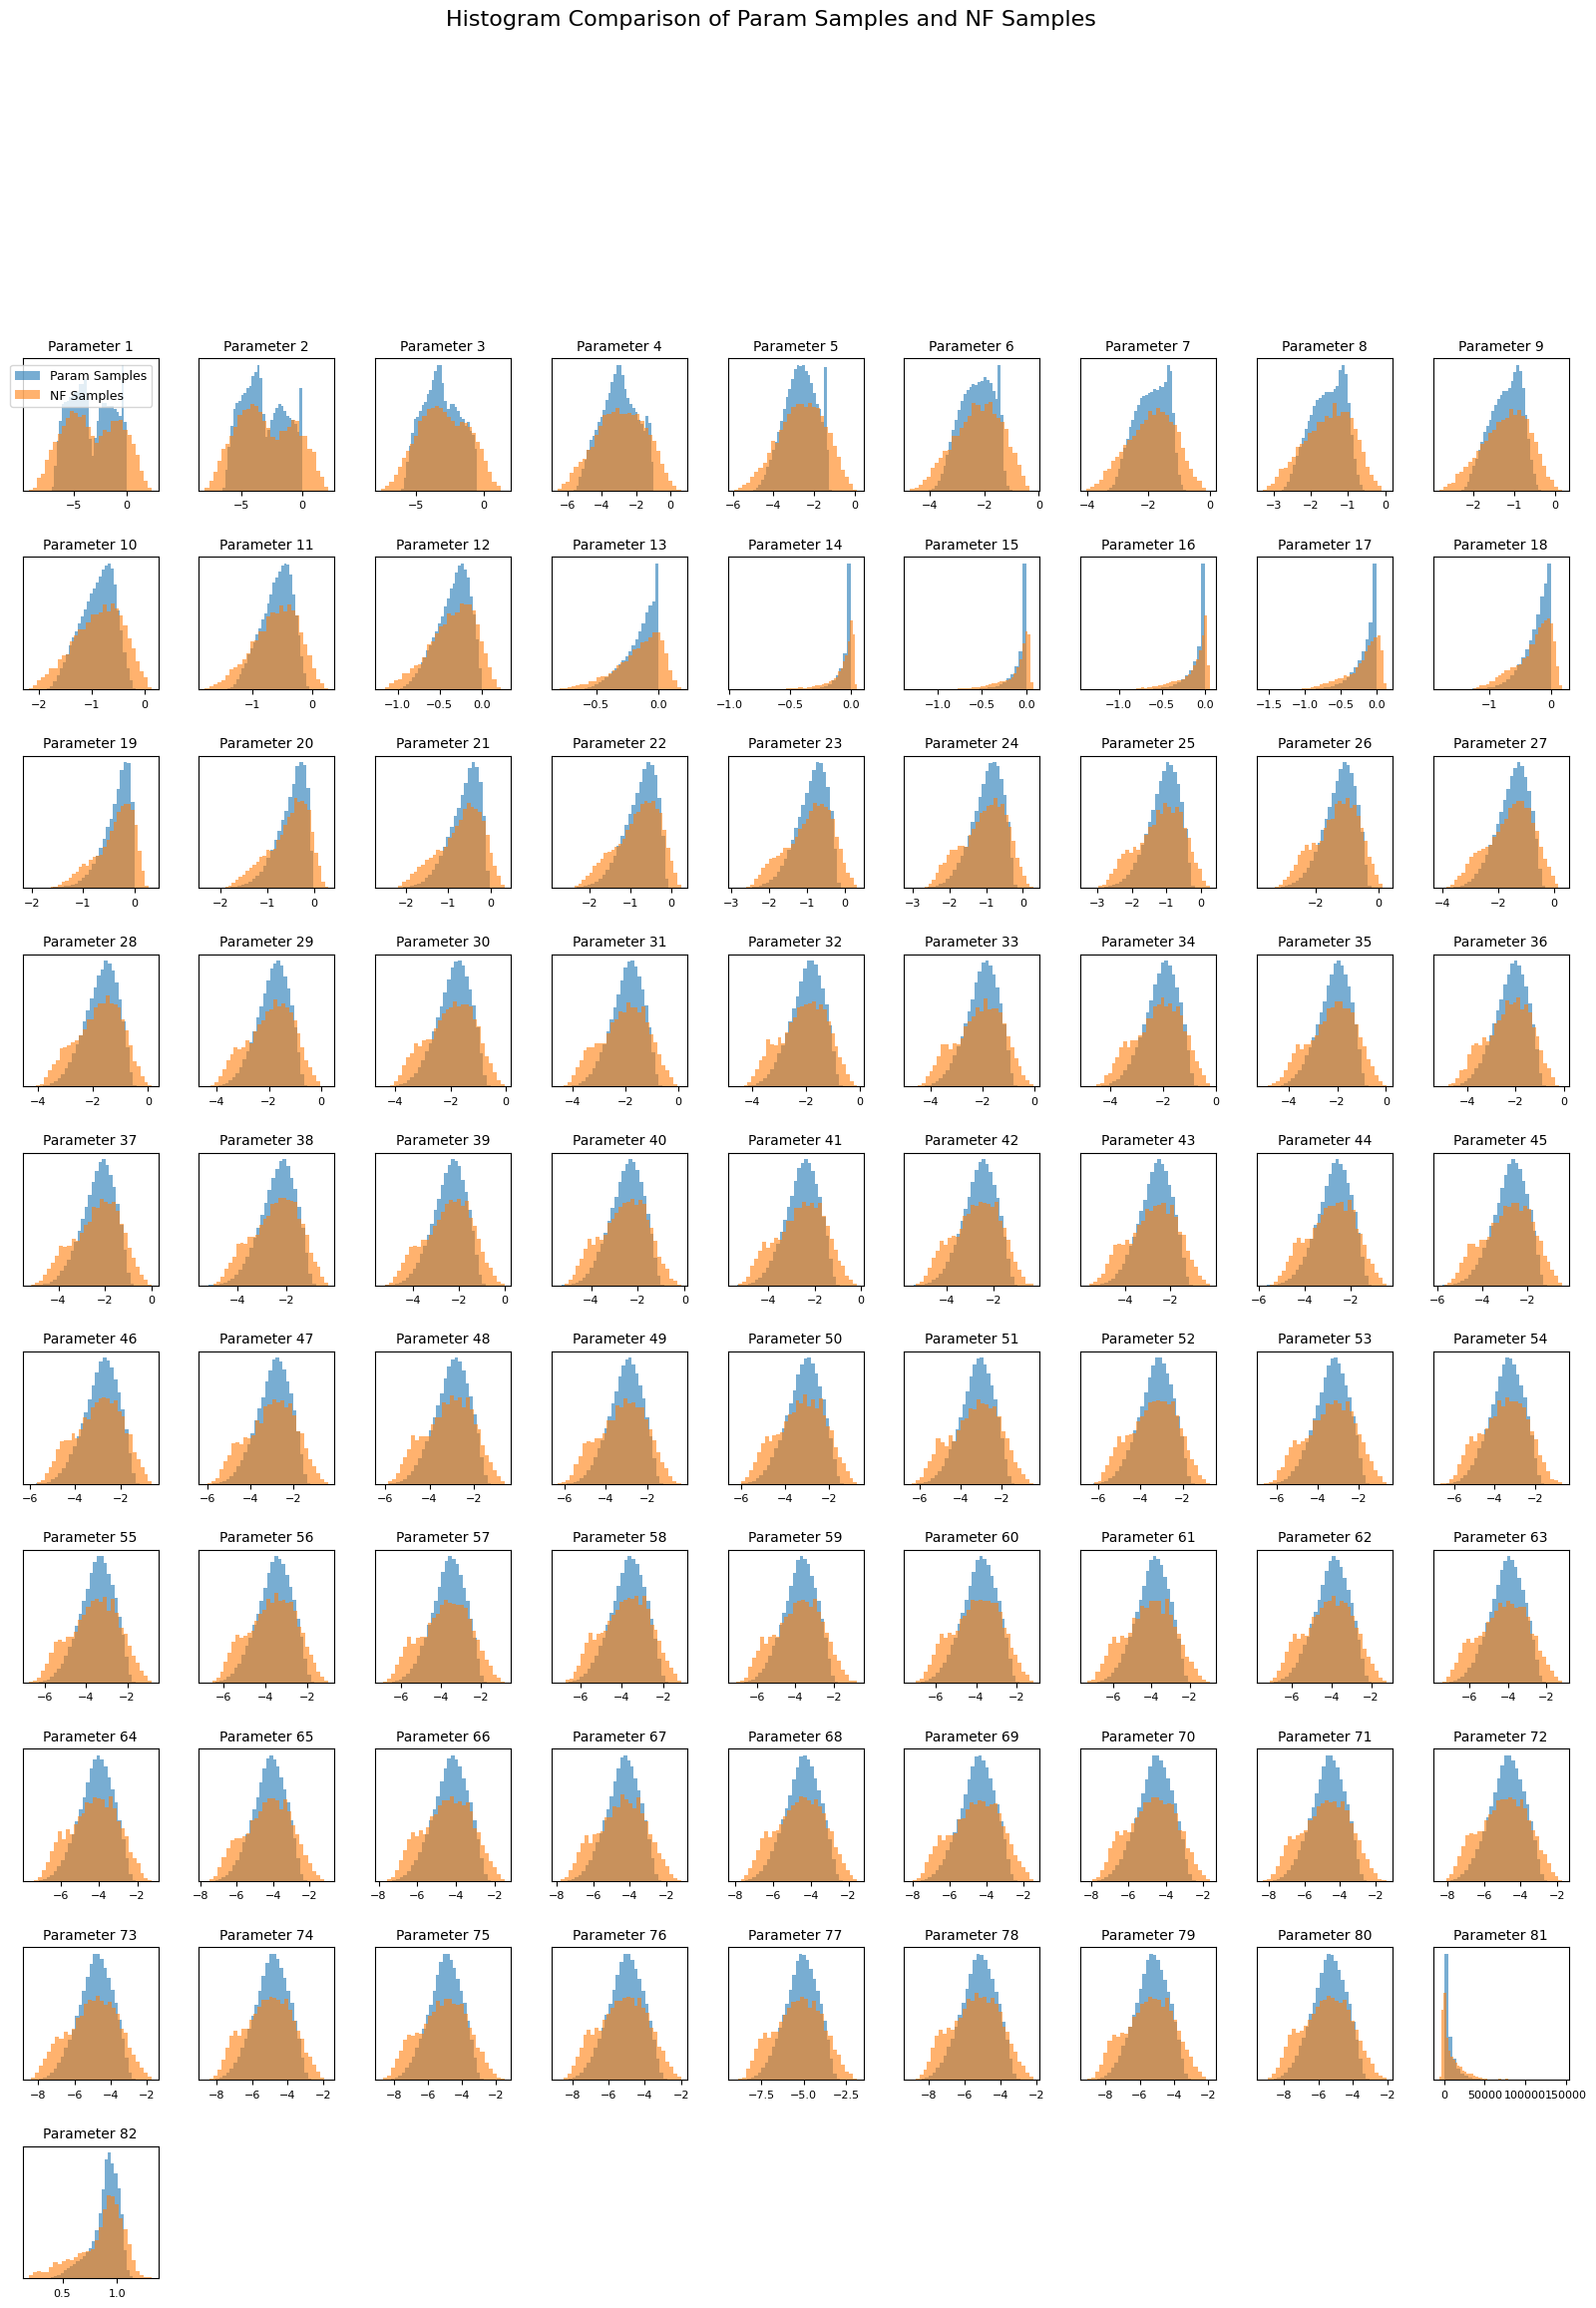

In [5]:
param_samples = params_array
num_samples = 10000
np.random.seed(0)

# Number of parameters
num_params = param_samples.shape[1]

# Set up the grid for subplots
n_cols = 9  # Number of columns in the grid
n_rows = int(np.ceil(num_params / n_cols))  # Calculate the number of rows needed

# Create a figure with specified size
fig = plt.figure(figsize=(20, 2.5 * n_rows))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.3, hspace=0.5)

# Define colors for the histograms
param_color = '#1f77b4'  # Blue
nf_color = '#ff7f0e'     # Orange

# Loop through each parameter and create histograms
for i in range(num_params):
    row = i // n_cols
    col = i % n_cols
    ax = plt.subplot(gs[row, col])
    
    # Plot histogram of param_samples for parameter i
    ax.hist(param_samples[:, i], bins=30, alpha=0.6, color=param_color, density=True, label='Param Samples')
    
    # Overlay histogram of nf_samples for parameter i
    ax.hist(nf_samples[:, i], bins=30, alpha=0.6, color=nf_color, density=True, label='NF Samples')
    
    # Set title and remove y-ticks for clarity
    ax.set_title(f'Parameter {i+1}', fontsize=10)
    ax.set_yticks([])
    
    # Adjust x-axis labels
    ax.tick_params(axis='x', labelsize=8)
    
    # Add legend to the first subplot
    if i == 0:
        ax.legend(fontsize=9)

# Remove any empty subplots
for i in range(num_params, n_rows * n_cols):
    fig.delaxes(plt.subplot(gs[i // n_cols, i % n_cols]))

# Add a main title for the entire figure
fig.suptitle('Histogram Comparison of Param Samples and NF Samples', fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [6]:
params_before = eqx.filter(model, eqx.is_array)


In [7]:
params_before

MaskedCouplingRQSpline(
  base_dist=Gaussian(_mean=f32[82], _cov=f32[82,82], learnable=None),
  layers=Sequential(
    layers=(
      MaskedCouplingLayer(
        _mask=bool[10,82],
        bijector=ScalarAffine(scale=f32[10], shift=f32[10])
      ),
      MaskedCouplingLayer(
        _mask=bool[10,82],
        bijector=RQSpline(
          _range_min=None,
          _range_max=None,
          _num_bins=None,
          _min_bin_size=None,
          _min_knot_slope=None,
          conditioner=MLP(
            layers=[
              Linear(
                weight=f32[10,128,82],
                bias=f32[10,128],
                in_features=82,
                out_features=128,
                use_bias=True
              ),
              None,
              Linear(
                weight=f32[10,128,128],
                bias=f32[10,128],
                in_features=128,
                out_features=128,
                use_bias=True
              ),
              None,
              Linear

In [8]:
model.save_model("test")

In [9]:
model2 = MaskedCouplingRQSpline(
    n_feature,
    n_layers,
    n_hiddens,
    n_bins,
    subkey,
    data_cov=None,
    data_mean=None,
)

In [10]:
model2 = model2.load_model("./test")

In [11]:
params_after = eqx.filter(model2, eqx.is_array)

In [12]:
print("params after:", params_after)

params after: MaskedCouplingRQSpline(
  base_dist=Gaussian(_mean=f32[82], _cov=f32[82,82], learnable=None),
  layers=Sequential(
    layers=(
      MaskedCouplingLayer(
        _mask=bool[10,82],
        bijector=ScalarAffine(scale=f32[10], shift=f32[10])
      ),
      MaskedCouplingLayer(
        _mask=bool[10,82],
        bijector=RQSpline(
          _range_min=None,
          _range_max=None,
          _num_bins=None,
          _min_bin_size=None,
          _min_knot_slope=None,
          conditioner=MLP(
            layers=[
              Linear(
                weight=f32[10,128,82],
                bias=f32[10,128],
                in_features=82,
                out_features=128,
                use_bias=True
              ),
              None,
              Linear(
                weight=f32[10,128,128],
                bias=f32[10,128],
                in_features=128,
                out_features=128,
                use_bias=True
              ),
              None,
      

In [13]:
key, subkey = jax.random.split(key, 2)
nf_samples = model2.sample(subkey, 10000, sigma_factor=2)

/scratch/tmp.11134737.areeves/ipykernel_1942453/3052891419.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


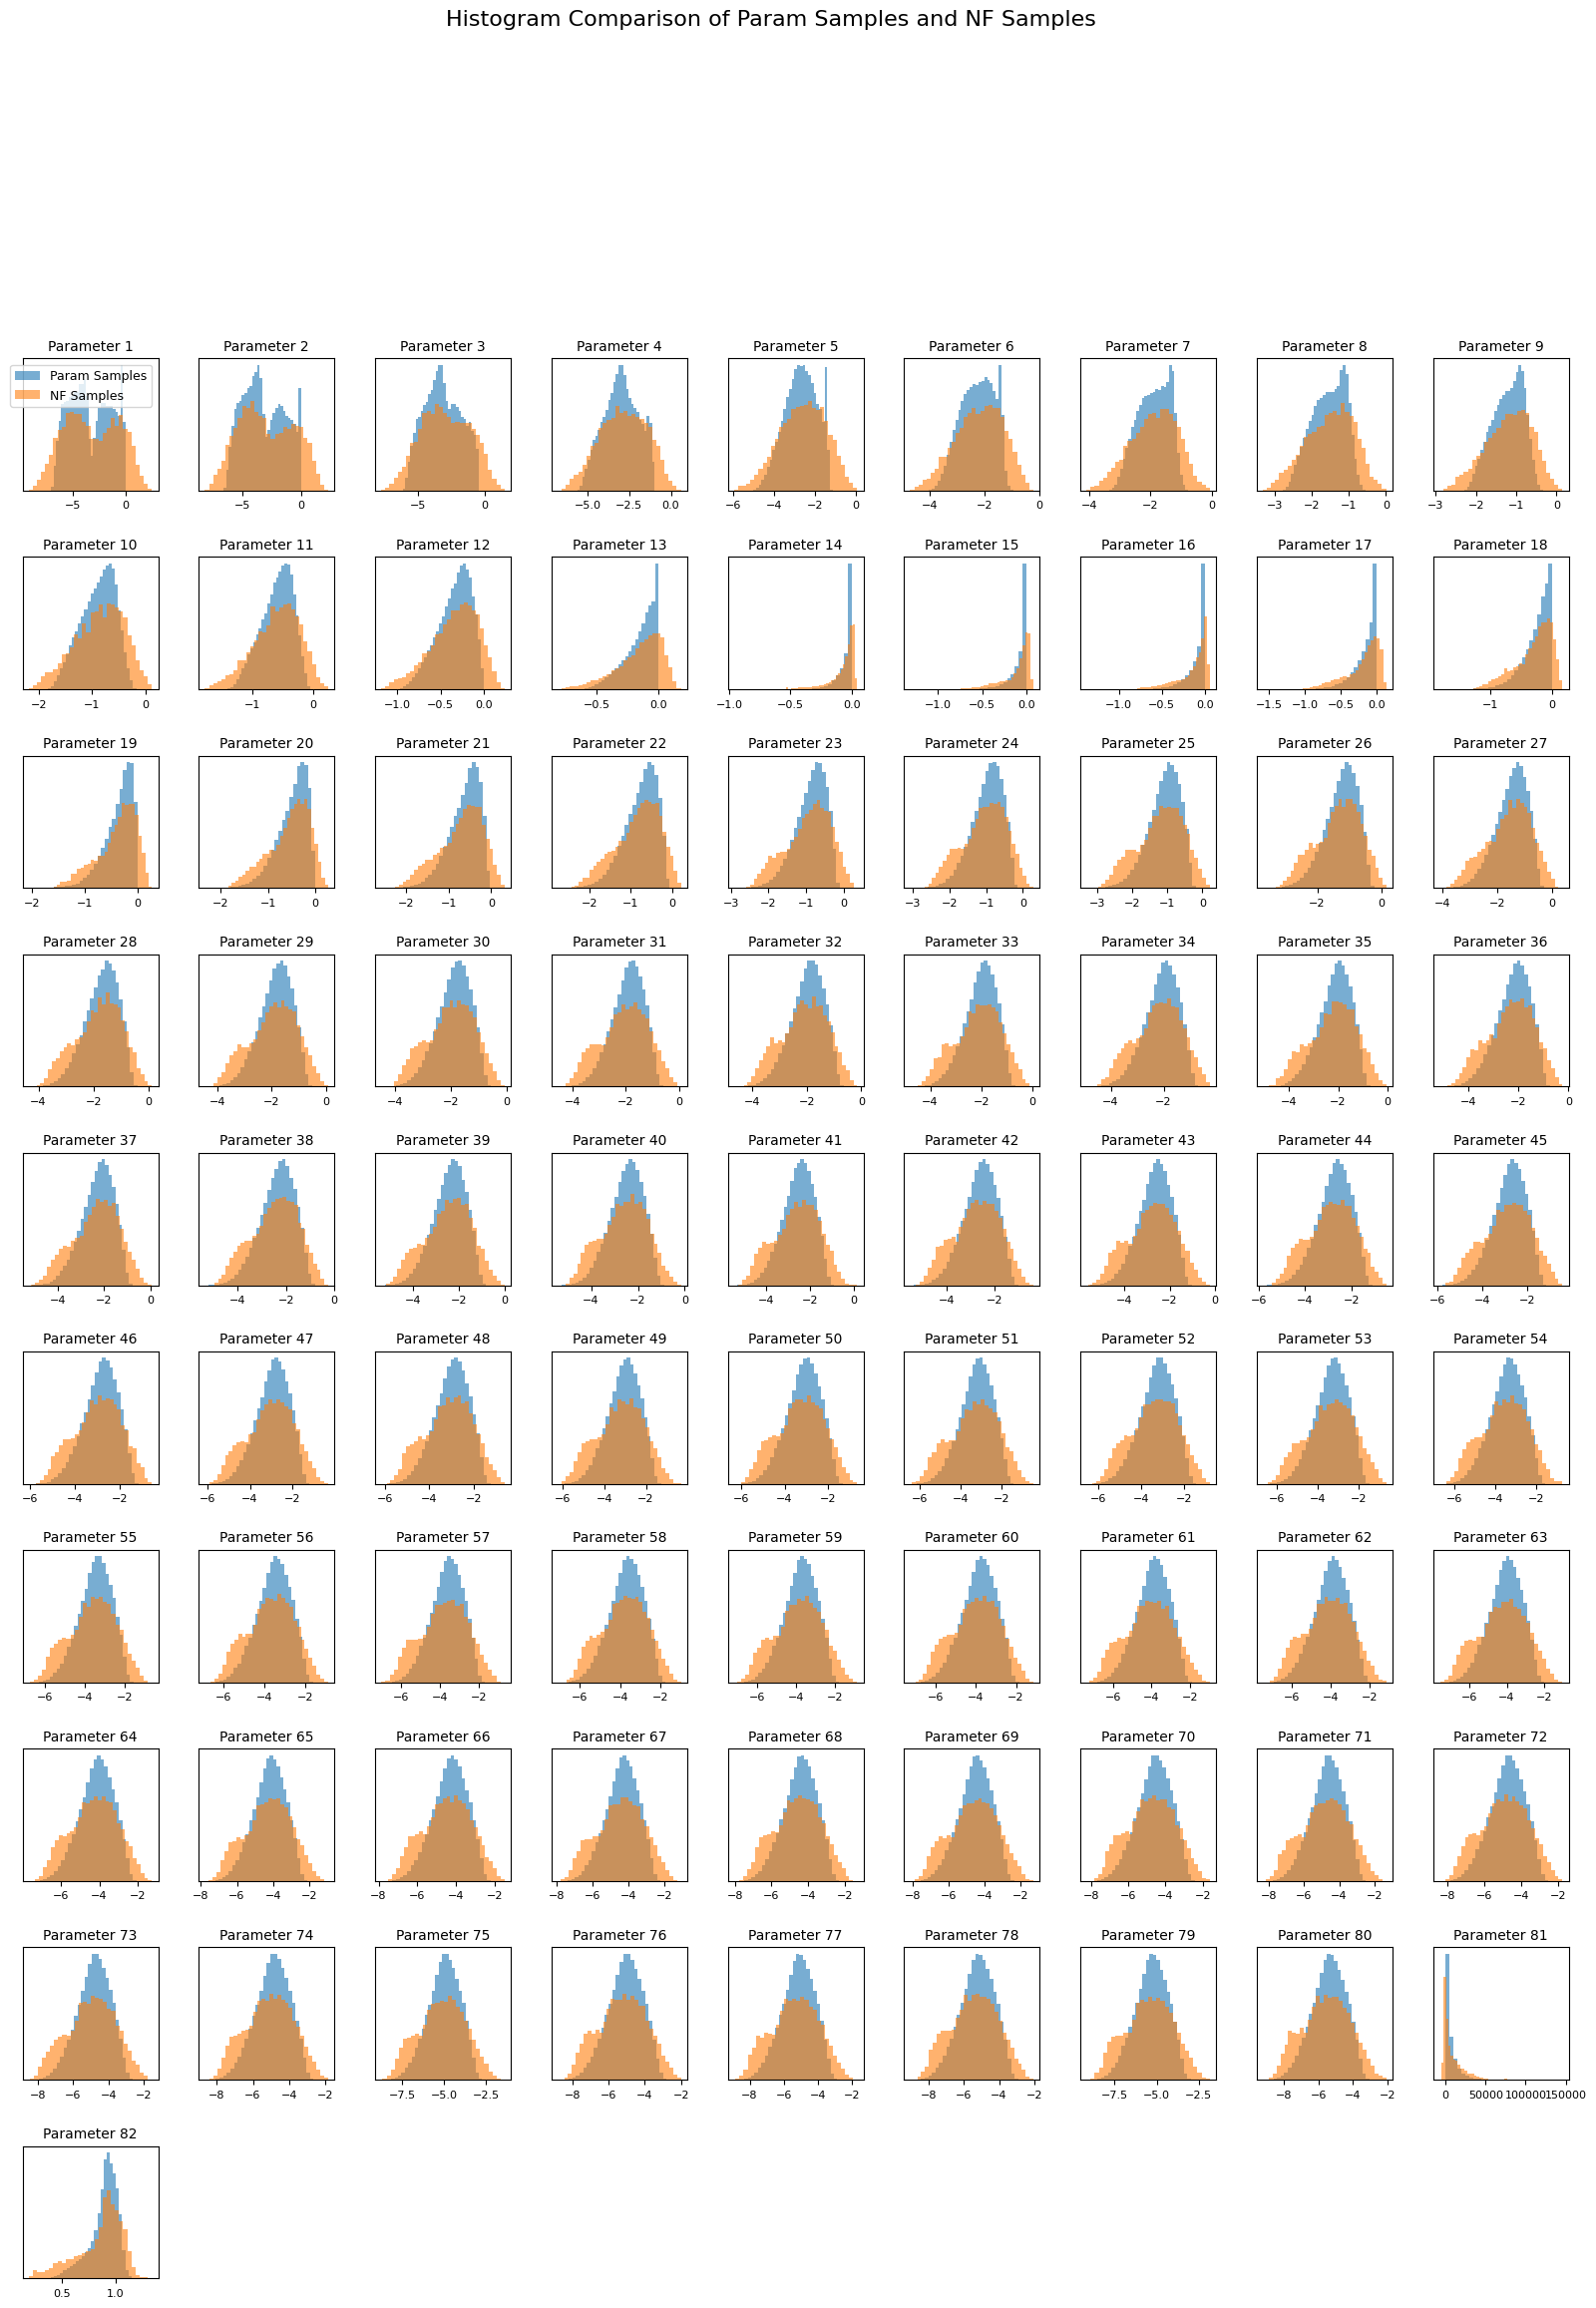

In [14]:
param_samples = params_array
num_samples = 10000
np.random.seed(0)

# Number of parameters
num_params = param_samples.shape[1]

# Set up the grid for subplots
n_cols = 9  # Number of columns in the grid
n_rows = int(np.ceil(num_params / n_cols))  # Calculate the number of rows needed

# Create a figure with specified size
fig = plt.figure(figsize=(20, 2.5 * n_rows))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.3, hspace=0.5)

# Define colors for the histograms
param_color = '#1f77b4'  # Blue
nf_color = '#ff7f0e'     # Orange

# Loop through each parameter and create histograms
for i in range(num_params):
    row = i // n_cols
    col = i % n_cols
    ax = plt.subplot(gs[row, col])
    
    # Plot histogram of param_samples for parameter i
    ax.hist(param_samples[:, i], bins=30, alpha=0.6, color=param_color, density=True, label='Param Samples')
    
    # Overlay histogram of nf_samples for parameter i
    ax.hist(nf_samples[:, i], bins=30, alpha=0.6, color=nf_color, density=True, label='NF Samples')
    
    # Set title and remove y-ticks for clarity
    ax.set_title(f'Parameter {i+1}', fontsize=10)
    ax.set_yticks([])
    
    # Adjust x-axis labels
    ax.tick_params(axis='x', labelsize=8)
    
    # Add legend to the first subplot
    if i == 0:
        ax.legend(fontsize=9)

# Remove any empty subplots
for i in range(num_params, n_rows * n_cols):
    fig.delaxes(plt.subplot(gs[i // n_cols, i % n_cols]))

# Add a main title for the entire figure
fig.suptitle('Histogram Comparison of Param Samples and NF Samples', fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [15]:
# model.save_model("test")